In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import wandb

from visualization import visualize as vis
from data import data_functions as df
from models import train_model as trm
from models import generate_model as gen

In [2]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, segmentation = self.dataset[idx]
        # Convert data to numpy arrays
        image = np.array(image)
        segmentation = np.array(segmentation)
        return image, segmentation

In [3]:
# Download the dataset with images & segmentations (as labels)
# resize the images & segmentations to be 224x224
train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                          split='trainval',
                          target_types='segmentation',
                          download=True,
                          transform=transforms.Resize((224, 224)),
                          target_transform=transforms.Resize((224, 224)))

# Convert downloaded data to jax compatible datasets/dataloaders
train_set = JaxDataset(dataset=train_set)
train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=64,
                              shuffle=True)
batch = next(iter(train_loader))

test_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                         split='test',
                         target_types='segmentation',
                         download=True,
                         transform=transforms.Resize((224, 224)),
                         target_transform=transforms.Resize((224, 224)))

test_set = JaxDataset(dataset=test_set)
test_loader = df.NumpyLoader(dataset=test_set, batch_size=64, shuffle=True)

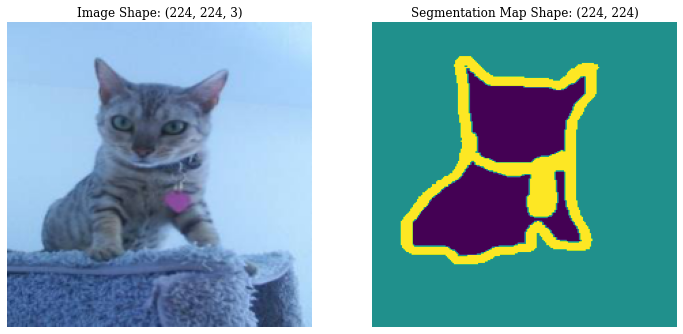

In [4]:
image, segmentation = batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image[0])
ax1.set_title(f"Image Shape: {image[0].shape}")
ax1.axis("off")

ax2.imshow(segmentation[0])
ax2.set_title(f"Segmentation Map Shape: {segmentation[0].shape}")
ax2.axis("off")

plt.show()

In [21]:
class DoubleConvolution(nn.Module):
    filters: int
    kernel_size: int = (3, 3)
    strides: int = (1, 1)
    padding: int = "SAME"

    def setup(self):
        self.conv1 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.act1 = nn.relu

        self.conv2 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.act2 = nn.relu

    def __call__(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        return x

class DownSample(nn.Module):
    window_shape: int = (2, 2)
    strides: int = (2, 2)
    padding: str = "VALID"

    def __call__(self, x):
        return nn.max_pool(x, window_shape=self.window_shape,
                           strides=self.strides, padding=self.padding)

class UpSample(nn.Module):
    filters: int
    kernel_size: int = (2, 2)
    strides: int = (2, 2)
    padding: Any = (1, 1)

    def setup(self):
        self.up_conv = nn.ConvTranspose(self.filters,
                                       self.kernel_size,
                                       strides=self.strides,
                                       padding=self.padding)

    def __call__(self, x):
        return self.up_conv(x)
        
class UNet(nn.Module):
    depth: int = 4
    initial_filters: int = 64
    output_channels: int = 3

    def setup(self):
        # Encoder 
        self.down_block1 = DoubleConvolution(self.initial_filters)
        self.down_block2 = DoubleConvolution(self.initial_filters*2)
        self.down_block3 = DoubleConvolution(self.initial_filters*4)
        self.down_block4 = DoubleConvolution(self.initial_filters*8)

        self.downsample_block1 = DownSample()
        self.downsample_block2 = DownSample()
        self.downsample_block3 = DownSample()
        self.downsample_block4 = DownSample()

        
        # Bottleneck 
        self.bottleneck_block = DoubleConvolution(self.initial_filters * 16)

        # Decoder
        self.up_sample4 = UpSample(self.initial_filters * 8)
        self.up_sample3 = UpSample(self.initial_filters * 4)
        self.up_sample2 = UpSample(self.initial_filters * 2)
        self.up_sample1 = UpSample(self.initial_filters)
        
        self.up_block4 = DoubleConvolution(self.initial_filters * 8)
        self.up_block3 = DoubleConvolution(self.initial_filters * 4)
        self.up_block2 = DoubleConvolution(self.initial_filters * 2)
        self.up_block1 = DoubleConvolution(self.initial_filters)

        # Final Convolutional Layer
        self.final_conv = nn.Conv(self.output_channels, 
                                  kernel_size=(1, 1),
                                  strides=(1, 1),
                                  padding="SAME")
    def __call__(self, x):
        skip_connections = []
        
        # Encoder path
        x = self.down_block1(x)
        skip_connections.append(x)
        x = self.downsample_block1(x)
        print('Encoder1 x.shape =', x.shape)

        x = self.down_block2(x)
        skip_connections.append(x)
        x = self.downsample_block2(x)
        print('Encoder1 x.shape =', x.shape)


        x = self.down_block3(x)
        skip_connections.append(x)
        x = self.downsample_block3(x)
        print('Encoder1 x.shape =', x.shape)

        x = self.down_block4(x)
        skip_connections.append(x)
        x = self.downsample_block4(x)
        print('Encoder1 x.shape =', x.shape)

        # Bottleneck
        x = self.bottleneck_block(x)
        print('Bottleneck x.shape =', x.shape)

        # Decoder path
        x = self.up_sample4(x)
        x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
        print('Skip_connection1 x.shape =', x.shape)
        x = self.up_block4(x)
        print('Decoder4 x.shape =', x.shape)

        x = self.up_sample3(x)
        x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
        print('Skip_connection3 x.shape =', x.shape)
        x = self.up_block3(x)
        print('Decoder3 x.shape =', x.shape)

        x = self.up_sample2(x)
        x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
        print('Skip_connection2 x.shape =', x.shape)
        x = self.up_block2(x)
        print('Decoder2 x.shape =', x.shape)

        x = self.up_sample1(x)
        x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
        print('Skip_connection1 x.shape =', x.shape)
        x = self.up_block1(x)
        print('Decoder1 x.shape =', x.shape)

        # Final Convolution layer
        x = self.final_conv(x)
        print('Final x.shape =', x.shape)

        return x 

model = UNet()
rng = random.PRNGKey(2)
print(model.tabulate(rng, jnp.ones((1, 224*2, 224*2, 3))))

Encoder1 x.shape = (1, 224, 224, 64)
Encoder1 x.shape = (1, 112, 112, 128)
Encoder1 x.shape = (1, 56, 56, 256)
Encoder1 x.shape = (1, 28, 28, 512)
Bottleneck x.shape = (1, 28, 28, 1024)
Skip_connection1 x.shape = (1, 56, 56, 1024)
Decoder4 x.shape = (1, 56, 56, 512)
Skip_connection3 x.shape = (1, 112, 112, 512)
Decoder3 x.shape = (1, 112, 112, 256)
Skip_connection2 x.shape = (1, 224, 224, 256)
Decoder2 x.shape = (1, 224, 224, 128)
Skip_connection1 x.shape = (1, 448, 448, 128)
Decoder1 x.shape = (1, 448, 448, 64)
Final x.shape = (1, 448, 448, 3)

                                             UNet Summary                                              
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module            ┃ inputs            ┃ outputs            ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                    │ UNet     

In [ ]:
# class DoubleConvolution(nn.Module):
#     filters: int
#     kernel_size: int = (3, 3)
#     strides: int = (1, 1)
#     padding: int = "SAME"

#     def setup(self):
#         self.conv1 = nn.Conv(self.filters, self.kernel_size,
#                              self.strides, padding=self.padding)
#         self.act1 = nn.relu

#         self.conv2 = nn.Conv(self.filters, self.kernel_size,
#                              self.strides, padding=self.padding)
#         self.act2 = nn.relu

#     def __call__(self, x):
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.act2(x)
#         return x

# class DownSample(nn.Module):
#     window_shape: int = (2, 2)
#     strides: int = (2, 2)
#     padding: str = "VALID"

#     def __call__(self, x):
#         return nn.max_pool(x, window_shape=self.window_shape,
#                            strides=self.strides, padding=self.padding)

# class UpSample(nn.Module):
#     filters: int
#     kernel_size: int = (2, 2)
#     strides: int = (2, 2)
#     padding: Any = (1, 1)

#     def setup(self):
#         self.up_conv = nn.ConvTranspose(self.filters,
#                                        self.kernel_size,
#                                        strides=self.strides,
#                                        padding=self.padding)

#     def __call__(self, x):
#         return self.up_conv(x)
        
# class UNet(nn.Module):
#     depth: int = 4
#     initial_filters: int = 64
#     output_channels: int = 3

#     def setup(self):
#         # Encoder 
#         self.down_block1 = DoubleConvolution(self.initial_filters)
#         self.down_block2 = DoubleConvolution(self.initial_filters*2)
#         self.down_block3 = DoubleConvolution(self.initial_filters*4)
#         self.down_block4 = DoubleConvolution(self.initial_filters*8)

#         self.downsample_block1 = DownSample()
#         self.downsample_block2 = DownSample()
#         self.downsample_block3 = DownSample()
#         self.downsample_block4 = DownSample()

        
#         # Bottleneck 
#         self.bottleneck_block = DoubleConvolution(self.initial_filters * 16)

#         # Decoder
#         self.up_sample4 = UpSample(self.initial_filters * 8)
#         self.up_sample3 = UpSample(self.initial_filters * 4)
#         self.up_sample2 = UpSample(self.initial_filters * 2)
#         self.up_sample1 = UpSample(self.initial_filters)
        
#         self.up_block4 = DoubleConvolution(self.initial_filters * 8)
#         self.up_block3 = DoubleConvolution(self.initial_filters * 4)
#         self.up_block2 = DoubleConvolution(self.initial_filters * 2)
#         self.up_block1 = DoubleConvolution(self.initial_filters)

#         # Final Convolutional Layer
#         self.final_conv = nn.Conv(self.output_channels, 
#                                   kernel_size=(1, 1),
#                                   strides=(1, 1),
#                                   padding="SAME")
#     def __call__(self, x):
#         skip_connections = []
        
#         # Encoder path
#         x = self.down_block1(x)
#         skip_connections.append(x)
#         x = self.downsample_block1(x)
#         print('Encoder1 x.shape =', x.shape)

#         x = self.down_block2(x)
#         skip_connections.append(x)
#         x = self.downsample_block2(x)
#         print('Encoder1 x.shape =', x.shape)


#         x = self.down_block3(x)
#         skip_connections.append(x)
#         x = self.downsample_block3(x)
#         print('Encoder1 x.shape =', x.shape)

#         x = self.down_block4(x)
#         skip_connections.append(x)
#         x = self.downsample_block4(x)
#         print('Encoder1 x.shape =', x.shape)

#         # Bottleneck
#         x = self.bottleneck_block(x)
#         print('Bottleneck x.shape =', x.shape)

#         # Decoder path
#         x = self.up_sample4(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection1 x.shape =', x.shape)
#         x = self.up_block4(x)
#         print('Decoder4 x.shape =', x.shape)

#         x = self.up_sample3(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection3 x.shape =', x.shape)
#         x = self.up_block3(x)
#         print('Decoder3 x.shape =', x.shape)

#         x = self.up_sample2(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection2 x.shape =', x.shape)
#         x = self.up_block2(x)
#         print('Decoder2 x.shape =', x.shape)

#         x = self.up_sample1(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection1 x.shape =', x.shape)
#         x = self.up_block1(x)
#         print('Decoder1 x.shape =', x.shape)

#         # Final Convolution layer
#         x = self.final_conv(x)
#         print('Final x.shape =', x.shape)

#         return x 

# model = UNet()
# rng = random.PRNGKey(2)
# print(model.tabulate(rng, jnp.ones((1, 224*2, 224*2, 3))))

# 3. Training Loop

In [4]:
config = {
    'seed': 47,
    'batch_size': 128,
    'learning_rate': 1e-4,
    'epochs': 20,
    'std_data': 0.5, 
    'in_features': 2,
    'out_features': 2,
    'D': 1024,
    'N': 2
}

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = UNet(in_features=config['in_features'],
             out_features=config['out_features'],
             std_data=config['std_data'])

# Sample the noise distribution
subkey4 = random.PRNGKey(32)
rnd_normal = random.normal(subkey4, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)  

# Initialize the models state
state = trm.init_train_state(model=model,
                               random_key=init_rng,
                               x_shape=batch.shape,
                               t_shape=t.shape,
                               learning_rate=config['learning_rate'])

# Call the training function
model, state = trm.train_model(train_loader, model, state, config, wandb_logging=True)

KeyboardInterrupt: 